In [4]:
# Linear algebra and data handling
import numpy as np
import pandas as pd

# Machine learning
from sklearn.ensemble import RandomForestRegressor, BaggingRegressor
from sklearn.model_selection import cross_validate, cross_val_predict, KFold
from sklearn.metrics import mean_absolute_error, median_absolute_error, classification_report, mean_squared_error
from sklearn.feature_selection import SelectKBest, f_regression, RFE
from sklearn.svm import SVR
from sklearn.preprocessing import (StandardScaler, Normalizer, RobustScaler,
                                    MaxAbsScaler)
from molprop_prediction.scripts.preprocess import *

#Visualization
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')
sns.set_context('talk', font_scale=1.5)
sns.set(color_codes=True)

#Extension to speed calculation (X10-100)
from sklearnex import patch_sklearn
patch_sklearn() 


Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


In [2]:
x_train = pd.read_csv('/home/onyxia/work/aml_project/data/raw_data/fixed_train_data.csv')
y_train = x_train['y']
x_test = pd.read_csv('/home/onyxia/work/aml_project/data/raw_data/fixed_test_data.csv')
y_test = x_test['y']
x_train =x_train.drop(columns=['y','Unnamed: 0'])
x_test =x_test.drop(columns=['y','Unnamed: 0'])
x_train

,id,smiles
0,122,O=C(CCc1cn(Cc2ccc(Cl)cc2)c2ccccc12)Nc1ccncc1
1,1769,COc1ccc(NC(=O)Nc2ccc3c(c2)c2c4c(c5c(c2n3CC(C)C...
2,1220,FC(F)(F)c1cccc(-c2nnc(-c3cccnc3NCc3ccncc3)[nH]...
3,44,COc1cc(Nc2ncnc(-c3cccnc3Nc3cccc(C(=O)Nc4ccc(Oc...
4,289,COc1cc2c(Nc3ccc(Cl)c(Cl)c3)ncnc2cc1OCc1csc(N2C...
...,...,...
3515,3444,CN[C@@H]1C[C@H]2O[C@@](C)([C@@H]1OC)N1C3=C(C4C...
3516,466,CNCc1cncc(-c2cnc3[nH]nc(-c4nc5ccc(OC(F)(F)F)cc...
3517,3092,Cc1ccc(Nc2ncnn3cc(OCCCN4CCCCC4)c(C(C)C)c23)cc1O
3518,3772,C=c1nns/c1=c1\[nH][nH]c(=O)c1=Cc1cn(C)c2ccc(Cl...


In [ ]:
new_train = create_our_dataset(x_train, 'smiles', 'mol', n = 8)
new_test = create_our_dataset(x_test, 'smiles', 'mol', n = 8)

In [6]:
from sklearn.feature_selection import SelectKBest, chi2

from sklearnex import patch_sklearn
patch_sklearn() 

transformer = RobustScaler().fit(new_train)
x_train_scaled=transformer.transform(new_train)
x_test_scaled=transformer.transform(new_test)


k_best = SelectKBest( k=400)
X_train_selected = k_best.fit_transform(x_train_scaled, y_train)
X_test_selected = k_best.transform(x_test_scaled)

regr = RandomForestRegressor(n_estimators = 100, 
                             max_depth = 30,
                             min_samples_split=2, 
                             min_samples_leaf= 1, 
                             warm_start = False, 
                             bootstrap = False,
                             max_features='sqrt',
                             n_jobs=-1)
regr.fit(X_train_selected, y_train)
y_train_predict= regr.predict(X_train_selected)
y_test_predict= regr.predict(X_test_selected)

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


/opt/mamba/lib/python3.10/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [   8   19   21   46  161  190  323  369  395  416  418  672  685  778
  801  817  832  879  893  941 1009 1061 1080 1119 1129 1329 1378 1382
 1390 1536 1543 1553 1598 1704 1782 1789 1935 1989 2013 2062 2113 2126
 2171 2200 2201 2202 2204 2206 2207 2208 2218 2219 2222 2229 2236 2237
 2241 2243 2250 2252] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/opt/mamba/lib/python3.10/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: divide by zero encountered in divide
  f = msb / msw
/opt/mamba/lib/python3.10/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


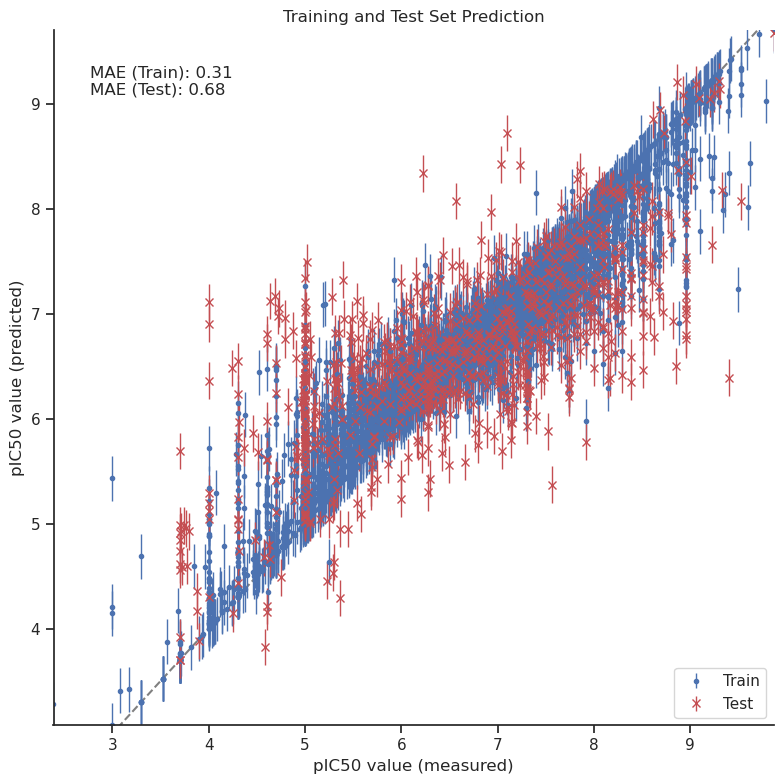

In [7]:
with sns.axes_style('ticks'):
    fig, ax = plt.subplots(figsize=(8, 8))

    ax.set_xlim([np.min(y_train), np.max(y_train)])
    ax.set_ylim([np.min(y_train_predict), np.max(y_train_predict)])

    ax.errorbar(y_train, y_train_predict, fmt='.', label='Train', lw=1., capsize=0, yerr=0.2*y_train_predict.std())
    ax.errorbar(y_test, y_test_predict, fmt='x', color='r', markeredgewidth=1., label='Test', lw=1., capsize=0, yerr=0.2*y_test_predict.std())

    ax.plot([-50, 110], [-50, 110], '--', zorder=0, color='gray')

    mae_train = mean_absolute_error(y_train, y_train_predict)
    mae_test = mean_absolute_error(y_test, y_test_predict)

    ax.set_title('Training and Test Set Prediction')
    ax.set_ylabel('pIC50 value (predicted)')
    ax.set_xlabel('pIC50 value (measured)')

    text = ('MAE (Train): {:.2f}'.format(mae_train) + '\n' +
            'MAE (Test): {:.2f}'.format(mae_test))

    ax.text(0.05, 0.95, text, transform=ax.transAxes, ha='left', va='top')
    
    ax.legend(loc='lower right')

    sns.despine()
    fig.tight_layout()
    
    #fig.savefig('y_prediction.png', transparent=True)


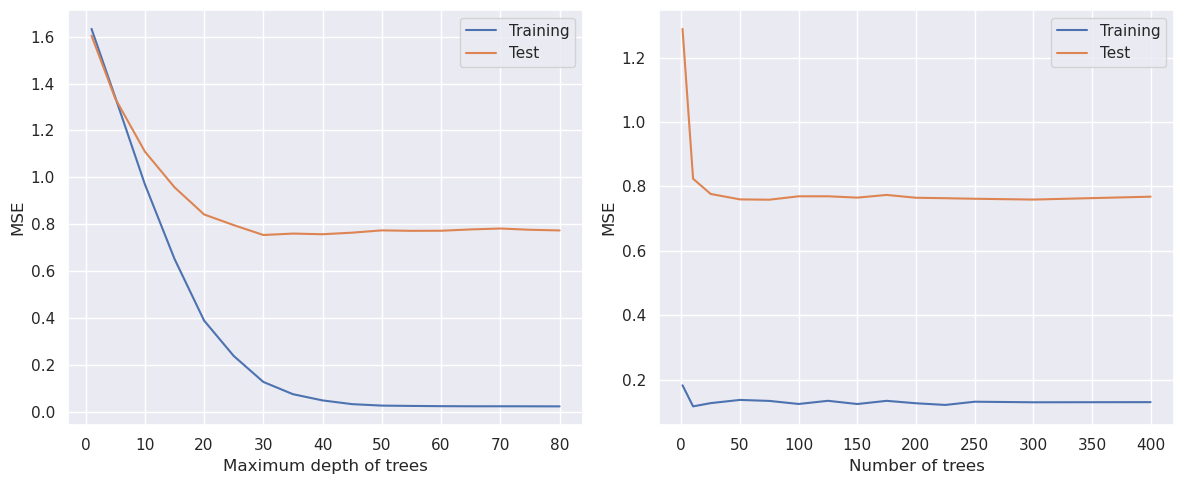

In [28]:
n_estimators_range = [1,10,25,50,75, 100,125, 150, 175,200,225,250, 300,400]
depht=[1,5, 10, 15,20,25, 30,35,40,45,50,55,60,65,70,75,80]


train_losses_nb_trees = []
test_losses_nb_trees = []

train_losses_d = []
test_losses_d = []

# Entraînement du modèle et évaluation de la MAE pour chaque nombre d'arbres
#for n_estimators in n_estimators_range:
for d in depht:
    model = RandomForestRegressor(max_depth=d,n_estimators = 100, 
                             min_samples_split=2, 
                             min_samples_leaf= 1, 
                             warm_start = False, 
                             bootstrap = False,
                             max_features='sqrt')
    model.fit(X_train_selected, y_train)
    y_train_pred_d = model.predict(X_train_selected)
    y_test_pred_d = model.predict(X_test_selected)
    
    # Calculez l'erreur de prédiction (MSE) et ajoutez-la à la liste
    train_loss_d = mean_squared_error(y_train, y_train_pred_d)
    test_loss_d = mean_squared_error(y_test, y_test_pred_d)
    
    train_losses_d.append(train_loss_d)
    test_losses_d.append(test_loss_d)

for n_estimators in n_estimators_range:
    model = RandomForestRegressor(max_depth=30,n_estimators = n_estimators, 
                             min_samples_split=2, 
                             min_samples_leaf= 1, 
                             warm_start = False, 
                             bootstrap = False,
                             max_features='sqrt')
    model.fit(X_train_selected, y_train)
    y_train_pred_nb_trees = model.predict(X_train_selected)
    y_test_pred_nb_trees = model.predict(X_test_selected)
    
    # Calculez l'erreur de prédiction (MSE) et ajoutez-la à la liste
    train_loss_nb_trees = mean_squared_error(y_train, y_train_pred_nb_trees)
    test_loss_nb_trees = mean_squared_error(y_test, y_test_pred_nb_trees)
    
    train_losses_nb_trees.append(train_loss_nb_trees)
    test_losses_nb_trees.append(test_loss_nb_trees)


plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(depht, train_losses_d, label='Training')
plt.plot(depht, test_losses_d, label='Test')
plt.xlabel('Maximum depth of trees')
plt.ylabel('MSE')
plt.legend()
#plt.title('Maximum depth of trees : Random Forest Performance')


plt.subplot(1, 2, 2)
plt.plot(n_estimators_range, train_losses_nb_trees, label='Training')
plt.plot(n_estimators_range, test_losses_nb_trees, label='Test')
plt.xlabel('Number of trees')
plt.ylabel('MSE')
plt.legend()
#plt.title('Number of trees : Random Forest Performance')

#plt.suptitle('Overfitting of Random Forest according to the number of trees and their maximum depth')

plt.tight_layout()
plt.show()